In [28]:
import warnings
warnings.filterwarnings("ignore")

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, precision_score, recall_score, f1_score
import lightgbm as lgb
import catboost as cbt
import xgboost as xgb
import time
from river import stream
from statistics import mode

In [30]:
df = pd.read_csv(r"C:\Users\gtroc\Jupyter Projects\CICIDS2017_sample_km.csv")

In [31]:
df.Label.value_counts()

0    18225
3     3042
6     2180
1     1966
5     1255
2       96
4       36
Name: Label, dtype: int64

In [32]:
X = df.drop(['Label'],axis=1)
y = df['Label']
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, test_size = 0.2, random_state = 0) #shuffle=False

In [33]:
pd.Series(y_train).value_counts()

0    14569
3     2430
6     1728
1     1579
5     1024
2       82
4       28
Name: Label, dtype: int64

In [34]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(n_jobs=-1,sampling_strategy={2:1000,4:1000})

In [35]:
X_train, y_train = smote.fit_resample(X_train, y_train)

In [36]:
pd.Series(y_train).value_counts()

0    14569
3     2430
6     1728
1     1579
5     1024
2     1000
4     1000
Name: Label, dtype: int64

Fitting 3 folds for each of 10 candidates, totalling 30 fits
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3656
           1       1.00      0.99      0.99       387
           2       1.00      1.00      1.00        14
           3       1.00      1.00      1.00       612
           4       1.00      0.75      0.86         8
           5       0.99      1.00      0.99       231
           6       1.00      1.00      1.00       452

    accuracy                           1.00      5360
   macro avg       1.00      0.96      0.98      5360
weighted avg       1.00      1.00      1.00      5360

Accuracy of LightGBM: 0.9973880597014926
Precision of LightGBM: 0.997397986822127
Recall of LightGBM: 0.9973880597014926
Average F1 of LightGBM: 0.9973617026402988
F1 of LightGBM for each type of attack: [0.99808691 0.99480519 1.         0.99754702 0.85714286 0.99354839
 0.99778271]


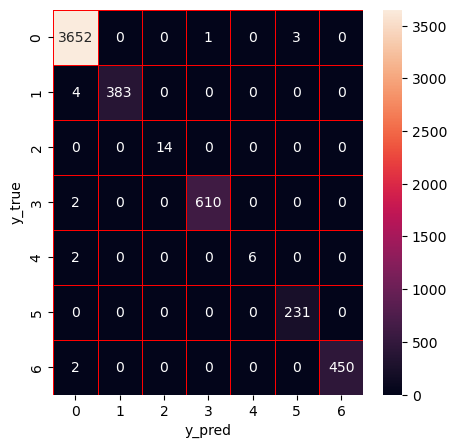

In [37]:
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier

lg = LGBMClassifier(objective='multiclass', random_state=42)

param_dist_lg = {
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30]
}

random_search_lg = RandomizedSearchCV(lg, param_distributions=param_dist_lg, scoring='f1_weighted', n_iter=10, cv=3, n_jobs=-1, verbose=2)
random_search_lg.fit(X_train, y_train)

best_lg = random_search_lg.best_estimator_
y_pred = best_lg.predict(X_test)

# LightGBM evaluation
y_pred_lg = best_lg.predict(X_test)
print(classification_report(y_test, y_pred_lg))
print("Accuracy of LightGBM: " + str(accuracy_score(y_test, y_pred_lg)))
print("Precision of LightGBM: " + str(precision_score(y_test, y_pred_lg, average='weighted')))
print("Recall of LightGBM: " + str(recall_score(y_test, y_pred_lg, average='weighted')))
print("Average F1 of LightGBM: " + str(f1_score(y_test, y_pred_lg, average='weighted')))
print("F1 of LightGBM for each type of attack: " + str(f1_score(y_test, y_pred_lg, average=None)))
lg_f1 = f1_score(y_test, y_pred_lg, average=None)

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred_lg)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3656
           1       0.99      0.99      0.99       387
           2       1.00      1.00      1.00        14
           3       1.00      1.00      1.00       612
           4       1.00      0.62      0.77         8
           5       0.99      1.00      0.99       231
           6       1.00      1.00      1.00       452

    accuracy                           1.00      5360
   macro avg       1.00      0.94      0.96      5360
weighted avg       1.00      1.00      1.00      5360

Accuracy of LightGBM: 0.9973880597014926
Precision of LightGBM: 0.9973965619244186
Recall of LightGBM: 0.9973880597014926
Average F1 of LightGBM: 0.9973247905178211
F1 of LightGBM for each type of attack: [0.99822332 0.99353169 1.         0.99836334 0.76923077 0.99354839
 0.99778271]


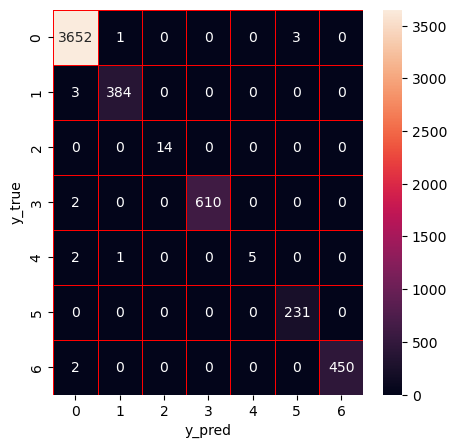

CPU times: total: 12.9 s
Wall time: 6.29 s


In [25]:
%%time
# Train the LightGBM algorithm
import lightgbm as lgb
lg = lgb.LGBMClassifier()
lg.fit(X_train, y_train)
y_pred = lg.predict(X_test)
print(classification_report(y_test,y_pred))
print("Accuracy of LightGBM: "+ str(accuracy_score(y_test, y_pred)))
print("Precision of LightGBM: "+ str(precision_score(y_test, y_pred, average='weighted')))
print("Recall of LightGBM: "+ str(recall_score(y_test, y_pred, average='weighted')))
print("Average F1 of LightGBM: "+ str(f1_score(y_test, y_pred, average='weighted')))
print("F1 of LightGBM for each type of attack: "+ str(f1_score(y_test, y_pred, average=None)))
lg_f1=f1_score(y_test, y_pred, average=None)

# Plot the confusion matrix
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [ ]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

# Prepare your data (X_train, y_train, X_test, y_test)

# Create an XGBoost classifier instance
xgb_clf = xgb.XGBClassifier(objective='multi:softmax', random_state=42)

# Define the hyperparameter search space
param_dist_xgb = {
    'max_depth': [10],
    'learning_rate': [.01],
    'n_estimators': [1000],
    'gamma': [0],
    'subsample': [.8],
    'colsample_bytree': [.8]
}

# Create a RandomizedSearchCV instance
random_search_xgb = RandomizedSearchCV(xgb_clf, param_distributions=param_dist_xgb, scoring='f1_weighted', n_iter=10, cv=3, n_jobs=-1, verbose=2)

# Fit the RandomizedSearchCV instance to your training data
random_search_xgb.fit(X_train, y_train)

# Get the best estimator and its score
best_xgb = random_search_xgb.best_estimator_
best_score = random_search_xgb.best_score_

# Predict using the best model
y_pred = best_xgb.predict(X_test)

# XGBoost evaluation
y_pred_xgb = best_xgb.predict(X_test)
print(classification_report(y_test, y_pred_xgb))
print("Accuracy of XGBoost: " + str(accuracy_score(y_test, y_pred_xgb)))
print("Precision of XGBoost: " + str(precision_score(y_test, y_pred_xgb, average='weighted')))
print("Recall of XGBoost: " + str(recall_score(y_test, y_pred_xgb, average='weighted')))
print("Average F1 of XGBoost: " + str(f1_score(y_test, y_pred_xgb, average='weighted')))
print("F1 of XGBoost for each type of attack: " + str(f1_score(y_test, y_pred_xgb, average=None)))
xgb_f1 = f1_score(y_test, y_pred_xgb, average=None)

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred_xgb)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()



In [ ]:
%%time
# Train the XGBoost algorithm
import xgboost as xgb
xg = xgb.XGBClassifier()

X_train_x = X_train.values
X_test_x = X_test.values

xg.fit(X_train_x, y_train)

y_pred = xg.predict(X_test_x)
print(classification_report(y_test,y_pred))
print("Accuracy of XGBoost: "+ str(accuracy_score(y_test, y_pred)))
print("Precision of XGBoost: "+ str(precision_score(y_test, y_pred, average='weighted')))
print("Recall of XGBoost: "+ str(recall_score(y_test, y_pred, average='weighted')))
print("Average F1 of XGBoost: "+ str(f1_score(y_test, y_pred, average='weighted')))
print("F1 of XGBoost for each type of attack: "+ str(f1_score(y_test, y_pred, average=None)))
xg_f1=f1_score(y_test, y_pred, average=None)

# Plot the confusion matrix
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [ ]:
import catboost as cb
from sklearn.model_selection import RandomizedSearchCV

# Prepare your data (X_train, y_train, X_test, y_test)

# Create a CatBoost classifier instance
cb_clf = cb.CatBoostClassifier(loss_function='MultiClass', random_state=42, verbose=0)

# Define the hyperparameter search space
param_dist_cb = {
    'iterations': [50, 100, 200, 300],
    'learning_rate': [0.001, 0.01, 0.1, 0.2],
    'depth': [4, 6, 8, 10],
    'l2_leaf_reg': [1, 3, 5, 7],
    'border_count': [32, 64, 128, 254],
    'bagging_temperature': [0, 1, 2, 3]
}

# Create a RandomizedSearchCV instance
random_search_cb = RandomizedSearchCV(cb_clf, param_distributions=param_dist_cb, scoring='f1_weighted', n_iter=10, cv=3, n_jobs=-1, verbose=2)

# Fit the RandomizedSearchCV instance to your training data
random_search_cb.fit(X_train, y_train)

# Get the best estimator and its score
best_cb = random_search_cb.best_estimator_
best_score = random_search_cb.best_score_

# Predict using the best model
y_pred = best_cb.predict(X_test)

# CatBoost evaluation
y_pred_cb = best_cb.predict(X_test)
print(classification_report(y_test, y_pred_cb))
print("Accuracy of CatBoost: " + str(accuracy_score(y_test, y_pred_cb)))
print("Precision of CatBoost: " + str(precision_score(y_test, y_pred_cb, average='weighted')))
print("Recall of CatBoost: " + str(recall_score(y_test, y_pred_cb, average='weighted')))
print("Average F1 of CatBoost: " + str(f1_score(y_test, y_pred_cb, average='weighted')))
print("F1 of CatBoost for each type of attack: " + str(f1_score(y_test, y_pred_cb, average=None)))
cb_f1 = f1_score(y_test, y_pred_cb, average=None)

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred_cb)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [ ]:
%%time
# Train the CatBoost algorithm
import catboost as cbt
cb = cbt.CatBoostClassifier(verbose=0,boosting_type='Plain')
#cb = cbt.CatBoostClassifier()

cb.fit(X_train, y_train)
y_pred = cb.predict(X_test)
print(classification_report(y_test,y_pred))
print("Accuracy of CatBoost: "+ str(accuracy_score(y_test, y_pred)))
print("Precision of CatBoost: "+ str(precision_score(y_test, y_pred, average='weighted')))
print("Recall of CatBoost: "+ str(recall_score(y_test, y_pred, average='weighted')))
print("Average F1 of CatBoost: "+ str(f1_score(y_test, y_pred, average='weighted')))
print("F1 of CatBoost for each type of attack: "+ str(f1_score(y_test, y_pred, average=None)))
cb_f1=f1_score(y_test, y_pred, average=None)

# Plot the confusion matrix
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [ ]:
# Leading model list for each class
model=[]
for i in range(len(lg_f1)):
    if max(lg_f1[i],xg_f1[i],cb_f1[i]) == lg_f1[i]:
        model.append(lg)
    elif max(lg_f1[i],xg_f1[i],cb_f1[i]) == xg_f1[i]:
        model.append(xg)
    else:
        model.append(cb)

In [ ]:
model

In [ ]:
def LCCDE(X_test, y_test, m1, m2, m3):
    i = 0
    t = []
    m = []
    yt = []
    yp = []
    l = []
    pred_l = []
    pro_l = []

    # For each class (normal or a type of attack), find the leader model
    for xi, yi in stream.iter_pandas(X_test, y_test):

        xi2=np.array(list(xi.values()))
        y_pred1 = m1.predict(xi2.reshape(1, -1))      # model 1 (LightGBM) makes a prediction on text sample xi
        y_pred1 = int(y_pred1[0])
        y_pred2 = m2.predict(xi2.reshape(1, -1))      # model 2 (XGBoost) makes a prediction on text sample xi
        y_pred2 = int(y_pred2[0])
        y_pred3 = m3.predict(xi2.reshape(1, -1))      # model 3 (Catboost) makes a prediction on text sample xi
        y_pred3 = int(y_pred3[0])

        p1 = m1.predict_proba(xi2.reshape(1, -1))     # The prediction probability (confidence) list of model 1 
        p2 = m2.predict_proba(xi2.reshape(1, -1))     # The prediction probability (confidence) list of model 2  
        p3 = m3.predict_proba(xi2.reshape(1, -1))     # The prediction probability (confidence) list of model 3  

        # Find the highest prediction probability among all classes for each ML model
        y_pred_p1 = np.max(p1)
        y_pred_p2 = np.max(p2)
        y_pred_p3 = np.max(p3)

        if y_pred1 == y_pred2 == y_pred3: # If the predicted classes of all the three models are the same
            y_pred = y_pred1 # Use this predicted class as the final predicted class

        elif y_pred1 != y_pred2 != y_pred3: # If the predicted classes of all the three models are different
            # For each prediction model, check if the predicted class’s original ML model is the same as its leader model
            if model[y_pred1]==m1: # If they are the same and the leading model is model 1 (LightGBM)
                l.append(m1)
                pred_l.append(y_pred1) # Save the predicted class
                pro_l.append(y_pred_p1) # Save the confidence

            if model[y_pred2]==m2: # If they are the same and the leading model is model 2 (XGBoost)
                l.append(m2)
                pred_l.append(y_pred2)
                pro_l.append(y_pred_p2)

            if model[y_pred3]==m3: # If they are the same and the leading model is model 3 (CatBoost)
                l.append(m3)
                pred_l.append(y_pred3)
                pro_l.append(y_pred_p3)

            if len(l)==0: # Avoid empty probability list
                pro_l=[y_pred_p1,y_pred_p2,y_pred_p3]

            elif len(l)==1: # If only one pair of the original model and the leader model for each predicted class is the same
                y_pred=pred_l[0] # Use the predicted class of the leader model as the final prediction class

            else: # If no pair or multiple pairs of the original prediction model and the leader model for each predicted class are the same
                max_p = max(pro_l) # Find the highest confidence
                
                # Use the predicted class with the highest confidence as the final prediction class
                if max_p == y_pred_p1:
                    y_pred = y_pred1
                elif max_p == y_pred_p2:
                    y_pred = y_pred2
                else:
                    y_pred = y_pred3  
        
        else: # If two predicted classes are the same and the other one is different
            n = mode([y_pred1,y_pred2,y_pred3]) # Find the predicted class with the majority vote
            y_pred = model[n].predict(xi2.reshape(1, -1)) # Use the predicted class of the leader model as the final prediction class
            y_pred = int(y_pred[0]) 

        yt.append(yi)
        yp.append(y_pred) # Save the predicted classes for all tested samples
    return yt, yp

In [ ]:
%%time
# Implementing LCCDE
yt, yp = LCCDE(X_test, y_test, m1 = lg, m2 = xg, m3 = cb)

In [ ]:
# The performance of the proposed lCCDE model
print("Accuracy of LCCDE: "+ str(accuracy_score(yt, yp)))
print("Precision of LCCDE: "+ str(precision_score(yt, yp, average='weighted')))
print("Recall of LCCDE: "+ str(recall_score(yt, yp, average='weighted')))
print("Average F1 of LCCDE: "+ str(f1_score(yt, yp, average='weighted')))
print("F1 of LCCDE for each type of attack: "+ str(f1_score(yt, yp, average=None)))

In [ ]:
# Comparison: The F1-scores for each base model
print("F1 of LightGBM for each type of attack: "+ str(lg_f1))
print("F1 of XGBoost for each type of attack: "+ str(xg_f1))
print("F1 of CatBoost for each type of attack: "+ str(cb_f1))